# Задача 1: регрессия

## Задание

* Проведите аналитику полученных данных
* Подготовьте данные для регрессионной модели
* Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
* Оцените качество модели с помощью функции metric

## Описание данных

* YEAR: год продажи
* MONTH: месяц продажи
* CONTRAGENT: поставщик товарной позиции
* ARTICLE_CODE: код товарной позиции
* ARTICLE_NAME: название товарной позиции
* ARTICLE_GROUP: название группы товарных позиций
* SALES: продажи товарной позиции в этот месяц и год (целевая переменная)
* STORE_SALES: продажи всего магазина

## Метрика

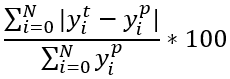

# Импорт необходимых библиотек

In [1]:
import nltk
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 25)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Вывод полных чисел
pd.set_option('float_format', '{:f}'.format)
import warnings
warnings.filterwarnings("ignore")

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Загрузка данных

In [2]:
data = pd.read_csv('data_regression_for_task.csv')
data

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.000000,0.000000
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.000000,0.000000
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.000000,0.000000
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.000000,0.000000
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.000000,0.000000
...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.000000,212.000000
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.000000,35.000000
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.000000,32.000000
128353,2018,2,NaN,BC,BEER CREDIT,REF,0.000000,-35.000000


# Исследование данных

## Размеры датасета

In [3]:
rows, cols = data.shape
print(f'Количество наблюдений: {rows}\nКоличество столбцов: {cols}')

Количество наблюдений: 128355
Количество столбцов: 8


## Информация о датасете

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


## Описание датасета

In [5]:
data.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128355.000000,128355.000000,128355.000000,128355.000000
mean,2017.206030,7.079303,6563.037435,22.624213
std,0.404454,3.645826,28924.944352,239.693277
min,2017.000000,1.000000,-6490.000000,-4996.000000
25%,2017.000000,5.000000,0.000000,0.000000
50%,2017.000000,8.000000,330.000000,1.000000
75%,2017.000000,10.000000,3250.000000,4.000000
max,2018.000000,12.000000,1616600.000000,16271.750000


## Проверка на пустые значения

In [6]:
data.isnull().sum()

YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

## Количество уникальных значений

In [7]:
data.nunique()

YEAR                 2
MONTH               10
CONTRAGENT         333
ARTICLE_CODE     23556
ARTICLE_NAME     23624
ARTICLE_GROUP        8
SALES             7019
STORE_SALES       2518
dtype: int64

## Матрица корреляции

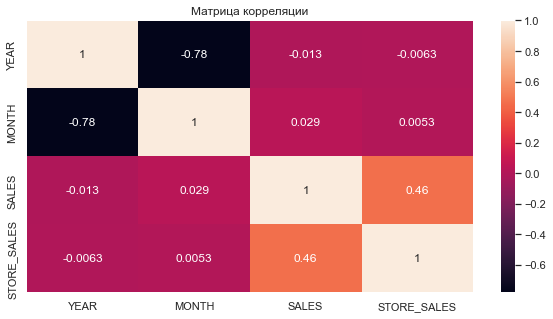

In [8]:
sns.set(rc={'figure.figsize':(10, 5)})
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.title('Матрица корреляции')
plt.show()

## Pandas Profile

In [9]:
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
def counter_print(counter):
    print('Количество появлений')
    i = 1
    for a, b in counter.most_common():
        print(f'{i}) \'{a}\' : {b}')
        i += 1

In [11]:
def sales_calculator(df, col_name, col_calc):
    col_unique_values = list(set(df[col_name]))
    sales_dict = {c: 0 for c in col_unique_values}
    for index, row in df.iterrows():
        sales_dict[row[col_name]] += row[col_calc]
    sales_dict_sort_by_value = {k: v for k, v in sorted(sales_dict.items(), key=lambda item: item[1], reverse=True)}
    return sales_dict_sort_by_value

## YEAR

### Количество уникальных значений и их появлений

In [12]:
set_year = list(set(data.YEAR))
print(f'Количество уникальных значений: {len(set_year)}\nСписок уникальных значений: {set_year}')

Количество уникальных значений: 2
Список уникальных значений: [2017, 2018]


In [13]:
counter_year = collections.Counter(data.YEAR)
counter_print(counter_year)

Количество появлений
1) '2017' : 101910
2) '2018' : 26445


### Гистограмма распределения

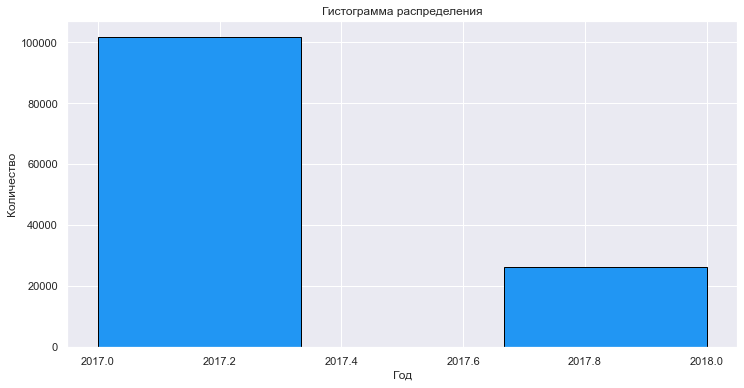

In [14]:
fig = plt.figure(figsize=(12, 6))
plt.hist(data.YEAR, bins=3, ec="black", color="#2196f3")
plt.title('Гистограмма распределения')
plt.ylabel('Количество')
plt.xlabel('Год')
plt.show()

### Продажи

In [15]:
year_store_sales = sales_calculator(data, 'YEAR', 'STORE_SALES')
print(f'STORE_SALES: {year_store_sales}')

STORE_SALES: {2017: 2384404.6399999904, 2018: 519526.1899999995}


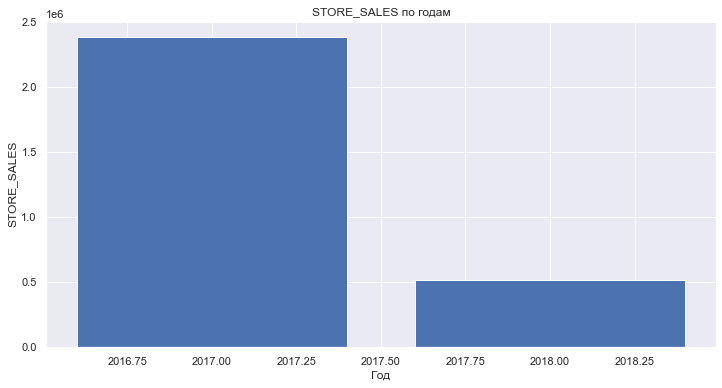

In [16]:
fig = plt.figure(figsize=(12, 6))
plt.bar(year_store_sales.keys(), year_store_sales.values())
plt.title('STORE_SALES по годам')
plt.ylabel('STORE_SALES')
plt.xlabel('Год')
plt.show()

In [17]:
year_sales = sales_calculator(data, 'YEAR', 'SALES')
print(f'SALES: {year_sales}')

SALES: {2017: 688802770.0, 2018: 153595900.0}


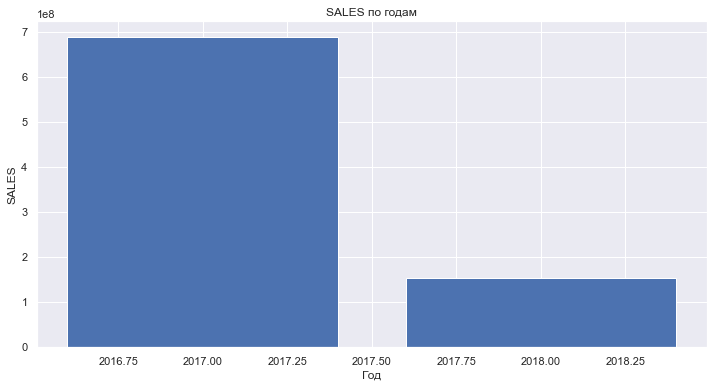

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.bar(year_sales.keys(), year_sales.values())
plt.title('SALES по годам')
plt.ylabel('SALES')
plt.xlabel('Год')
plt.show()

## MONTH

### Количество уникальных значений и их появлений

In [19]:
set_month = list(set(data.MONTH))
print(f'Количество уникальных значений: {len(set_month)}\nСписок уникальных значений: {set_month}')

Количество уникальных значений: 10
Список уникальных значений: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12]


In [20]:
counter_month = collections.Counter(data.MONTH)
counter_print(counter_month)

Количество появлений
1) '11' : 14532
2) '12' : 14500
3) '6' : 13628
4) '10' : 13626
5) '8' : 13590
6) '5' : 13453
7) '9' : 13386
8) '1' : 13345
9) '2' : 13100
10) '4' : 5195


### Гистограмма распределения

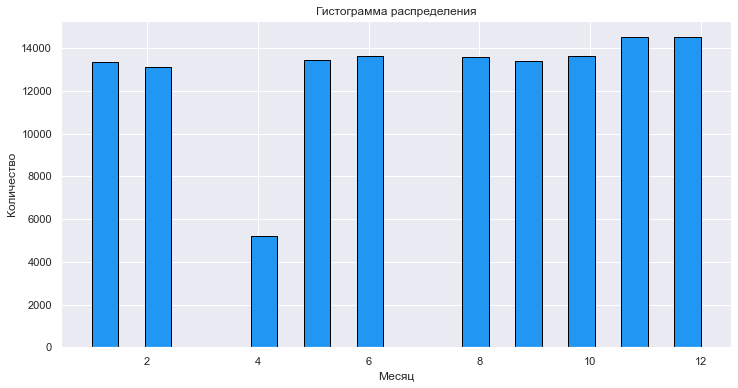

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.hist(data.MONTH, bins=23, ec="black", color="#2196f3")
plt.title('Гистограмма распределения')
plt.ylabel('Количество')
plt.xlabel('Месяц')
plt.show()

### Продажи

In [22]:
month_store_sales = sales_calculator(data, 'MONTH', 'STORE_SALES')
print(f'STORE_SALES: {month_store_sales}')

STORE_SALES: {8: 382186.6900000003, 6: 379390.8300000002, 5: 367408.80000000045, 11: 339305.6600000003, 12: 306957.22000000015, 9: 305440.5299999999, 10: 303714.9100000001, 2: 265008.5200000001, 1: 254517.66999999993, 4: 0.0}


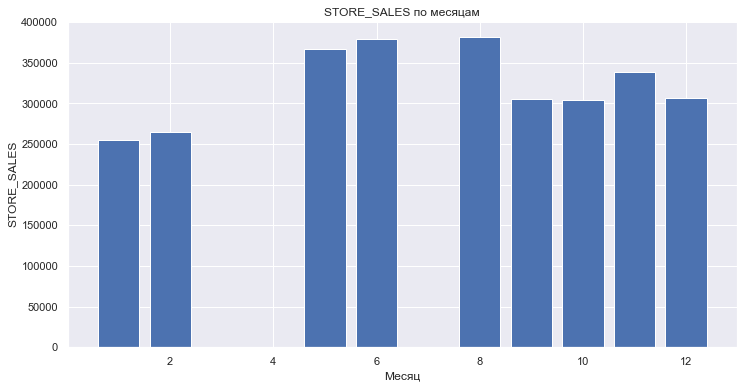

In [23]:
fig = plt.figure(figsize=(12, 6))
plt.bar(month_store_sales.keys(), month_store_sales.values())
plt.title('STORE_SALES по месяцам')
plt.ylabel('STORE_SALES')
plt.xlabel('Месяц')
plt.show()

In [24]:
month_sales = sales_calculator(data, 'MONTH', 'SALES')
print(f'SALES: {month_sales}')

SALES: {12: 131634490.0, 11: 98316190.0, 6: 97357260.0, 5: 94693490.0, 9: 90452600.0, 10: 89236960.0, 8: 87111780.0, 2: 77804130.0, 1: 75791770.0, 4: 0.0}


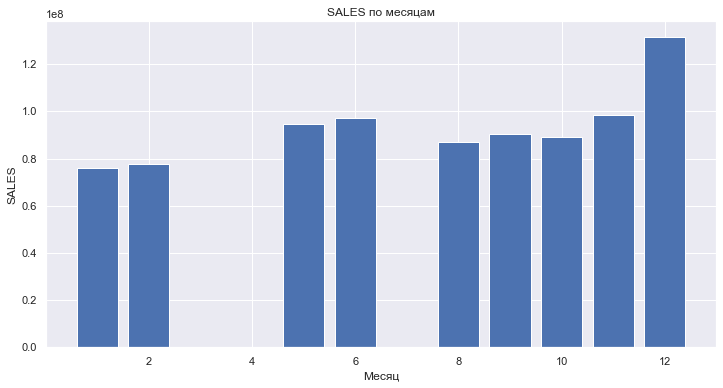

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.bar(month_sales.keys(), month_sales.values())
plt.title('SALES по месяцам')
plt.ylabel('SALES')
plt.xlabel('Месяц')
plt.show()

## CONTRAGENT

### Количество уникальных значений и их появлений

In [26]:
data.CONTRAGENT = data.CONTRAGENT.fillna('UNKNOWN')

In [27]:
set_contragent = list(set(data.CONTRAGENT))
print(f'Количество уникальных значений: {len(set_contragent)}\nСписок уникальных значений: {set_contragent}')

Количество уникальных значений: 334
Список уникальных значений: ['BOSTON BEER CORPORATION', 'FIVE GRAPES LLC', 'MARQUEE SELECTIONS LLC', 'WASHBURN WINE CO', 'MERRYVALE VINEYARDS', 'EVEREST SPIRITS LLC', 'FREE RUN WINE MERCHANTS LLC', 'WEIN-BAUER INC', 'STE MICHELLE WINE ESTATES', 'ST KILLIAN IMPORTING CO INC', 'THE RIVER WINE', 'DC BRAU BREWING LLC', 'MHW LTD', 'LABATT USA OPERATING CO LLC', 'WHITE ROCK DISTILLERS INC', 'MONOCACY BREWING CO LLC', 'BANVILLE & JONES WINE MERCHANTS', 'AMERICAN BEVERAGE MARKETERS', 'LEGENDS LTD', 'NOVELTY MD INC', 'INTERBALT PRODUCTS CORP', 'BOORDY VINEYARDS', 'BRONCO WINE COMPANY', 'CHEVAL QUANCARD', 'JOHN GIVEN WINES INC', 'ROBERT KACHER SELECTIONS LLC', 'J LOHR WINERY', 'CAPE STARZ WINE LLC', 'SAN ANTONIO WINERY INC', 'ARCHER ROOSE LLC', 'CAMPARI AMERICA LLC', 'THE WINE SOURCE INC', 'COPPER CANE LLC', 'ELK RUN VINEYARDS', 'LA ISLA CORPORATION', 'NARRAGANSETT BREWING COMPANY', 'ROBERT GIRAUD', 'STOLI GROUP (USA) LLC', 'BINDING BRAUEREI USA INC', 'BARREL 

In [28]:
counter_contragent = collections.Counter(data.CONTRAGENT)
counter_print(counter_contragent)

Количество появлений
1) 'REPUBLIC NATIONAL DISTRIBUTING CO' : 9847
2) 'A VINTNERS SELECTIONS' : 8716
3) 'LEGENDS LTD' : 5494
4) 'SOUTHERN GLAZERS WINE AND SPIRITS' : 4713
5) 'E & J GALLO WINERY' : 4669
6) 'BACCHUS IMPORTERS LTD' : 4383
7) 'MONSIEUR TOUTON SELECTION' : 4259
8) 'DIAGEO NORTH AMERICA INC' : 3333
9) 'RELIABLE CHURCHILL LLLP' : 2864
10) 'CONSTELLATION BRANDS' : 2851
11) 'JIM BEAM BRANDS CO' : 2743
12) 'DOPS INC' : 2503
13) 'PERNOD RICARD USA LLC' : 2404
14) 'ANHEUSER BUSCH INC' : 2143
15) 'CONSTANTINE WINES INC' : 1985
16) 'OPICI FAMILY DISTRIBUTING OF MD' : 1943
17) 'PRESTIGE BEVERAGE GROUP OF MD LLC' : 1890
18) 'TREASURY WINE ESTATES AMERICAS COMPANY' : 1812
19) 'THE WINE GROUP' : 1770
20) 'DIONYSOS IMPORTS INC' : 1668
21) 'ROYAL WINE CORP' : 1659
22) 'KYSELA PERE ET FILS LTD' : 1652
23) 'PUNTO VINO LLC' : 1605
24) 'BACARDI USA INC' : 1517
25) 'SAZERAC CO' : 1506
26) 'INTERBALT PRODUCTS CORP' : 1311
27) 'MILLER BREWING COMPANY' : 1290
28) 'LANTERNA DISTRIBUTORS INC' : 129

### Продажи

In [29]:
contragent_store_sales = sales_calculator(data, 'CONTRAGENT', 'STORE_SALES')
print(f'STORE_SALES: {contragent_store_sales}')

STORE_SALES: {'CROWN IMPORTS': 579824.7000000003, 'MILLER BREWING COMPANY': 572623.4100000001, 'ANHEUSER BUSCH INC': 493856.18999999965, 'HEINEKEN USA': 318812.59, 'E & J GALLO WINERY': 75594.98999999996, 'DIAGEO NORTH AMERICA INC': 54252.87999999999, 'YUENGLING BREWERY': 53805.32, 'BOSTON BEER CORPORATION': 53420.90999999999, 'PABST BREWING CO': 49815.91999999997, 'FLYING DOG BREWERY LLLP': 47227.219999999994, 'CONSTELLATION BRANDS': 44968.75999999998, 'LEGENDS LTD': 35945.96, 'A VINTNERS SELECTIONS': 29776.66999999999, 'REPUBLIC NATIONAL DISTRIBUTING CO': 27864.189999999988, 'THE WINE GROUP': 26603.78, 'DOGFISH HEAD CRAFT BREWERY': 25562.45, 'SIERRA NEVADA BREWING CO': 22799.46, 'SUTTER HOME WINERY INC': 22063.840000000004, 'NEW BELGIUM BREWING INC': 14874.31, 'SOUTHERN GLAZERS WINE AND SPIRITS': 14106.87, 'DEUTSCH FAMILY WINE & SPIRITS': 12851.53, 'JACKSON FAMILY ENTERPRISES INC': 12644.25, 'TREASURY WINE ESTATES AMERICAS COMPANY': 12591.68, 'BUCK DISTRIBUTING COMPANY INC': 12583.05

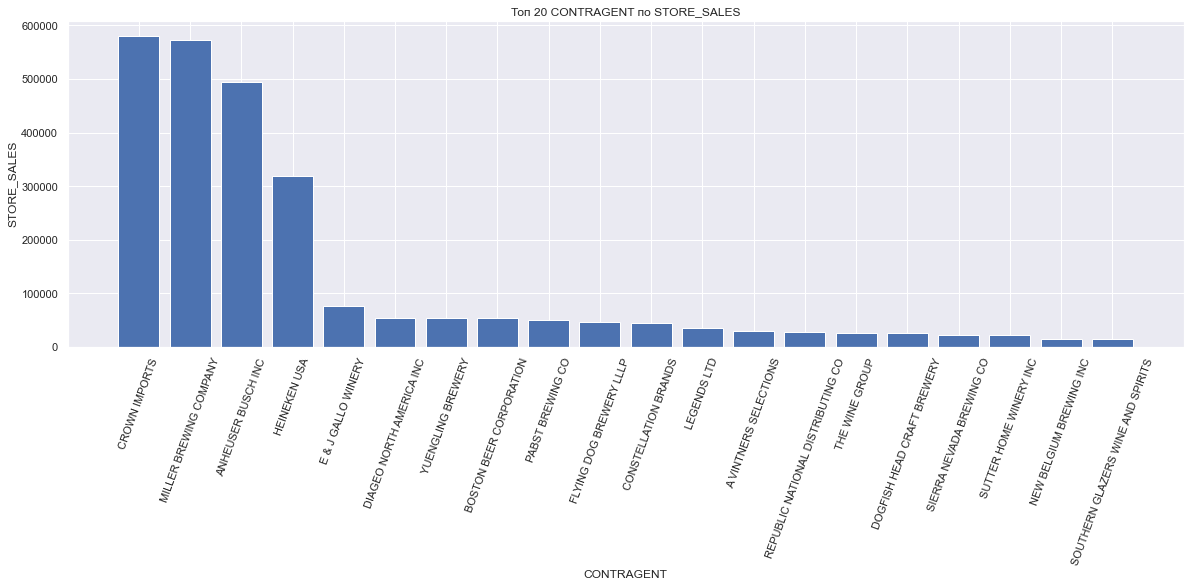

In [30]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(contragent_store_sales.keys())[:20], list(contragent_store_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 CONTRAGENT по STORE_SALES')
plt.ylabel('STORE_SALES')
plt.xlabel('CONTRAGENT')
plt.show()

In [31]:
contragent_sales = sales_calculator(data, 'CONTRAGENT', 'SALES')
print(f'SALES: {contragent_sales}')

SALES: {'E & J GALLO WINERY': 67455630.0, 'DIAGEO NORTH AMERICA INC': 57656360.0, 'CONSTELLATION BRANDS': 54472510.0, 'ANHEUSER BUSCH INC': 42559140.0, 'JIM BEAM BRANDS CO': 39156790.0, 'MILLER BREWING COMPANY': 35022630.0, 'BACARDI USA INC': 28034630.0, 'CROWN IMPORTS': 26707830.0, 'SAZERAC CO': 25772630.0, 'THE WINE GROUP': 25758150.0, 'PERNOD RICARD USA LLC': 24988550.0, 'BROWN-FORMAN BEVERAGES WORLDWIDE': 21659410.0, 'HEINEKEN USA': 20923170.0, 'HEAVEN HILL DISTILLERIES INC': 18462940.0, 'TREASURY WINE ESTATES AMERICAS COMPANY': 16701420.0, 'DEUTSCH FAMILY WINE & SPIRITS': 13927430.0, 'DELICATO FAMILY VINEYARDS': 13540650.0, 'REPUBLIC NATIONAL DISTRIBUTING CO': 13010150.0, 'FIFTH GENERATION INC': 12993550.0, 'PROXIMO SPIRITS INC': 11514640.0, 'JACKSON FAMILY ENTERPRISES INC': 10893990.0, 'WILLIAM GRANT AND SONS INC': 10813730.0, 'BOSTON BEER CORPORATION': 10773250.0, 'SUTTER HOME WINERY INC': 10522610.0, 'FLYING DOG BREWERY LLLP': 10301080.0, 'YUENGLING BREWERY': 9628350.0, 'RELIAB

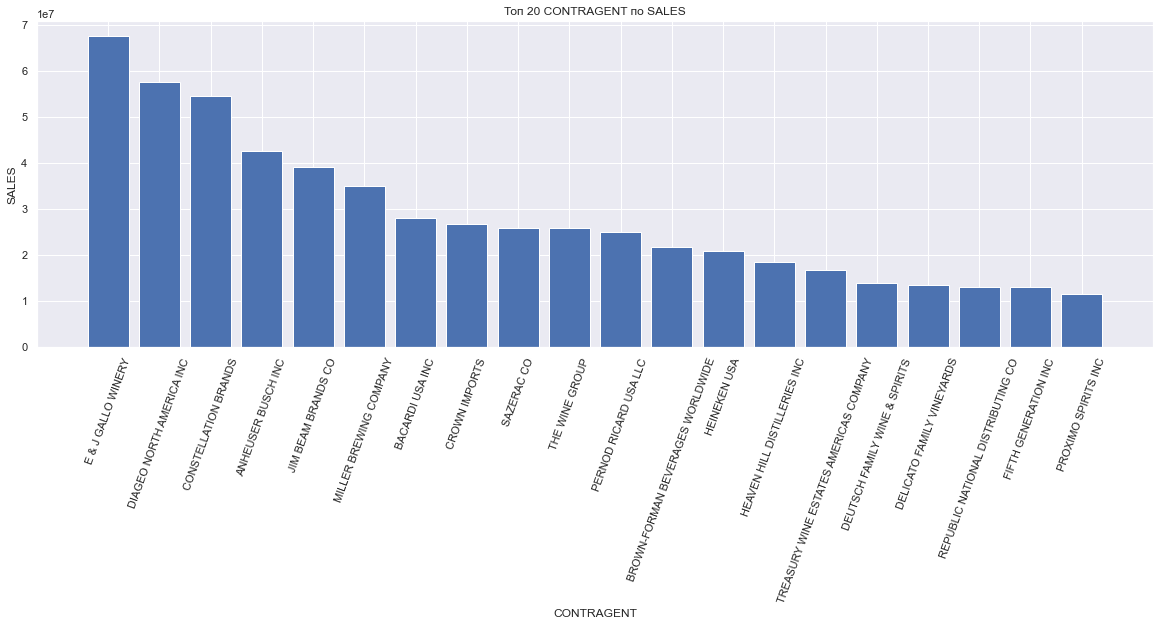

In [32]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(contragent_sales.keys())[:20], list(contragent_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 CONTRAGENT по SALES')
plt.ylabel('SALES')
plt.xlabel('CONTRAGENT')
plt.show()

## ARTICLE_CODE

### Количество уникальных значений и их появлений

In [33]:
set_article_code = list(set(data.ARTICLE_CODE))
#print(f'Количество уникальных значений: {len(set_article_code)}\nСписок уникальных значений: {set_article_code}')

In [34]:
counter_article_code = collections.Counter(data.ARTICLE_CODE)
#counter_print(counter_article_code)

### Продажи

In [35]:
article_code_store_sales = sales_calculator(data, 'ARTICLE_CODE', 'STORE_SALES')
#print(f'STORE_SALES: {article_code_store_sales}')

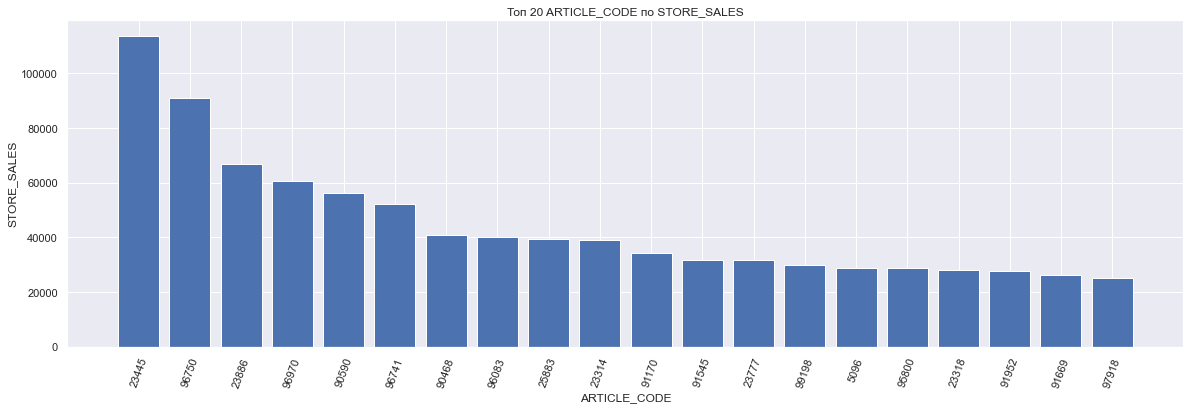

In [36]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(article_code_store_sales.keys())[:20], list(article_code_store_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 ARTICLE_CODE по STORE_SALES')
plt.ylabel('STORE_SALES')
plt.xlabel('ARTICLE_CODE')
plt.show()

In [37]:
article_code_sales = sales_calculator(data, 'ARTICLE_CODE', 'SALES')
#print(f'SALES: {article_code_sales}')

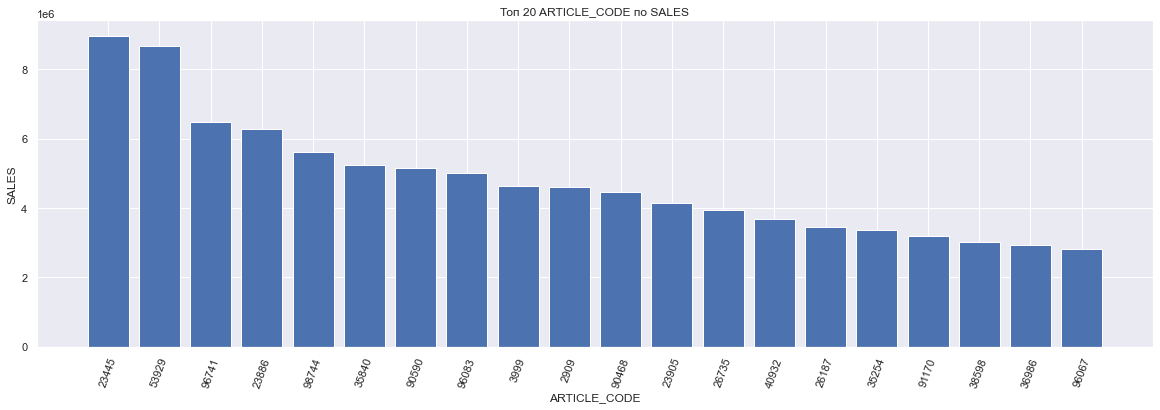

In [38]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(article_code_sales.keys())[:20], list(article_code_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 ARTICLE_CODE по SALES')
plt.ylabel('SALES')
plt.xlabel('ARTICLE_CODE')
plt.show()

## ARTICLE_NAME

### Количество уникальных значений и их появлений

In [39]:
set_article_name = list(set(data.ARTICLE_NAME))
#print(f'Количество уникальных значений: {len(set_article_name)}\nСписок уникальных значений: {set_article_name}')

In [40]:
counter_article_name = collections.Counter(data.ARTICLE_NAME)
#counter_print(counter_article_name)

### Продажи

In [41]:
article_name_store_sales = sales_calculator(data, 'ARTICLE_NAME', 'STORE_SALES')
#print(f'STORE_SALES: {article_name_store_sales}')

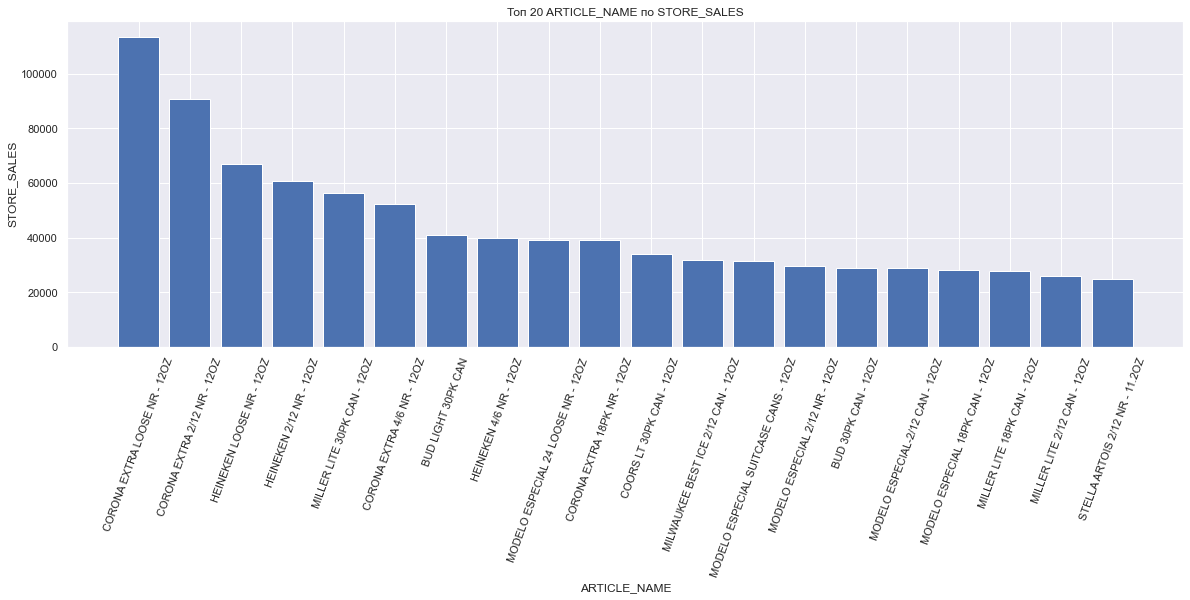

In [42]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(article_name_store_sales.keys())[:20], list(article_name_store_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 ARTICLE_NAME по STORE_SALES')
plt.ylabel('STORE_SALES')
plt.xlabel('ARTICLE_NAME')
plt.show()

In [43]:
article_name_sales = sales_calculator(data, 'ARTICLE_NAME', 'SALES')
#print(f'SALES: {article_name_sales}')

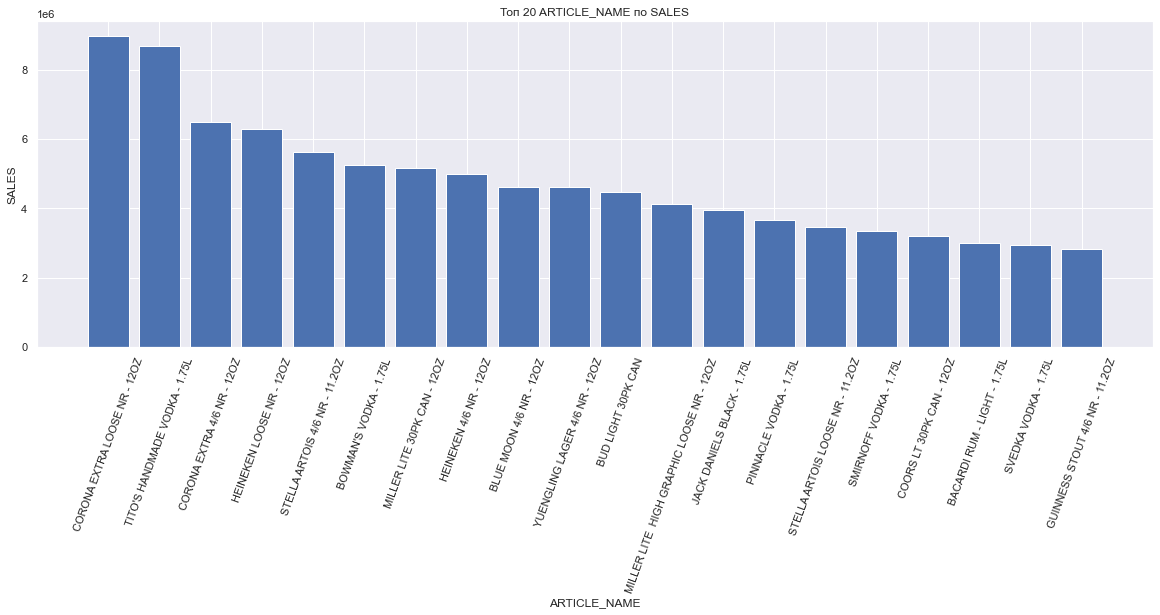

In [44]:
fig = plt.figure(figsize=(20, 6))
plt.bar(list(article_name_sales.keys())[:20], list(article_name_sales.values())[:20])
plt.xticks(rotation=70)
plt.title('Топ 20 ARTICLE_NAME по SALES')
plt.ylabel('SALES')
plt.xlabel('ARTICLE_NAME')
plt.show()

## ARTICLE_GROUP

### Количество уникальных значений и их появлений

In [45]:
data.ARTICLE_GROUP = data.ARTICLE_GROUP.fillna('UNKNOWN')

In [46]:
set_article_group = list(set(data.ARTICLE_GROUP))
print(f'Количество уникальных значений: {len(set_article_group)}\nСписок уникальных значений: {set_article_group}')

Количество уникальных значений: 9
Список уникальных значений: ['WINE', 'NON-ALCOHOL', 'REF', 'STR_SUPPLIES', 'BEER', 'LIQUOR', 'KEGS', 'UNKNOWN', 'DUNNAGE']


In [47]:
counter_article_group = collections.Counter(data.ARTICLE_GROUP)
counter_print(counter_article_group)

Количество появлений
1) 'WINE' : 79077
2) 'LIQUOR' : 28397
3) 'BEER' : 16425
4) 'KEGS' : 3638
5) 'NON-ALCOHOL' : 628
6) 'STR_SUPPLIES' : 106
7) 'REF' : 51
8) 'DUNNAGE' : 32
9) 'UNKNOWN' : 1


### Продажи

In [48]:
article_group_store_sales = sales_calculator(data, 'ARTICLE_GROUP', 'STORE_SALES')
print(f'STORE_SALES: {article_group_store_sales}')

STORE_SALES: {'BEER': 2437617.319999994, 'WINE': 433009.4699999996, 'KEGS': 43558.0, 'LIQUOR': 33173.31999999996, 'NON-ALCOHOL': 8656.720000000001, 'UNKNOWN': 1.0, 'STR_SUPPLIES': 0.0, 'REF': -6754.0, 'DUNNAGE': -45331.0}


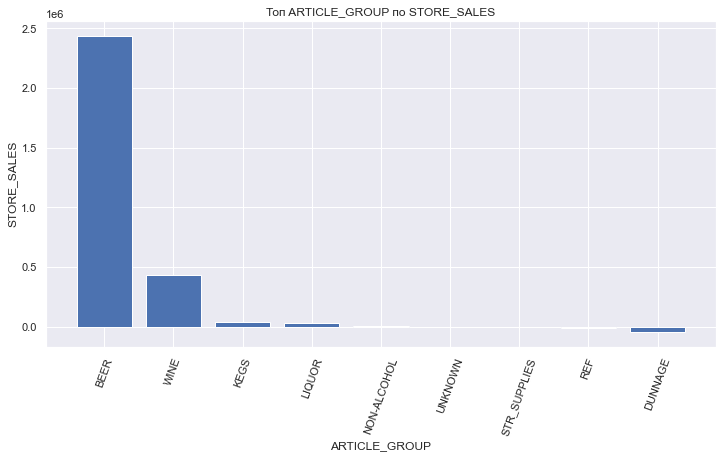

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.bar(article_group_store_sales.keys(), article_group_store_sales.values())
plt.xticks(rotation=70)
plt.title('Топ ARTICLE_GROUP по STORE_SALES')
plt.ylabel('STORE_SALES')
plt.xlabel('ARTICLE_GROUP')
plt.show()

In [50]:
article_group_sales = sales_calculator(data, 'ARTICLE_GROUP', 'SALES')
print(f'SALES: {article_group_sales}')

SALES: {'WINE': 313400420.0, 'LIQUOR': 309847850.0, 'BEER': 209763110.0, 'NON-ALCOHOL': 8109970.0, 'STR_SUPPLIES': 995980.0, 'REF': 281340.0, 'KEGS': 0.0, 'UNKNOWN': 0.0, 'DUNNAGE': 0.0}


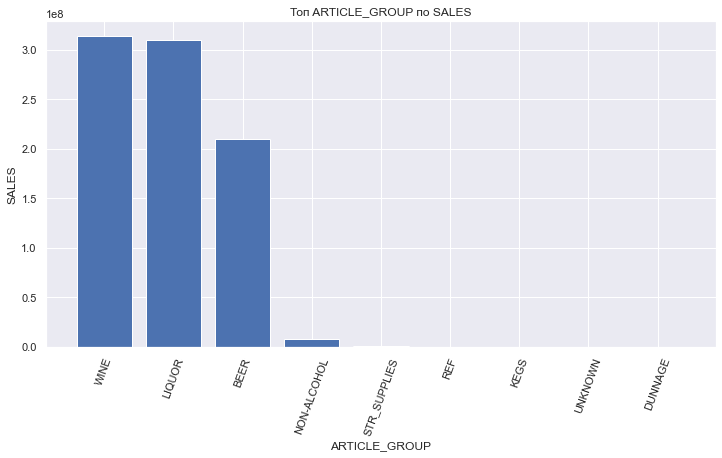

In [51]:
fig = plt.figure(figsize=(12, 6))
plt.bar(article_group_sales.keys(), article_group_sales.values())
plt.xticks(rotation=70)
plt.title('Топ ARTICLE_GROUP по SALES')
plt.ylabel('SALES')
plt.xlabel('ARTICLE_GROUP')
plt.show()

## STORE_SALES

In [52]:
data.STORE_SALES.describe()

count   128355.000000
mean        22.624213
std        239.693277
min      -4996.000000
25%          0.000000
50%          1.000000
75%          4.000000
max      16271.750000
Name: STORE_SALES, dtype: float64

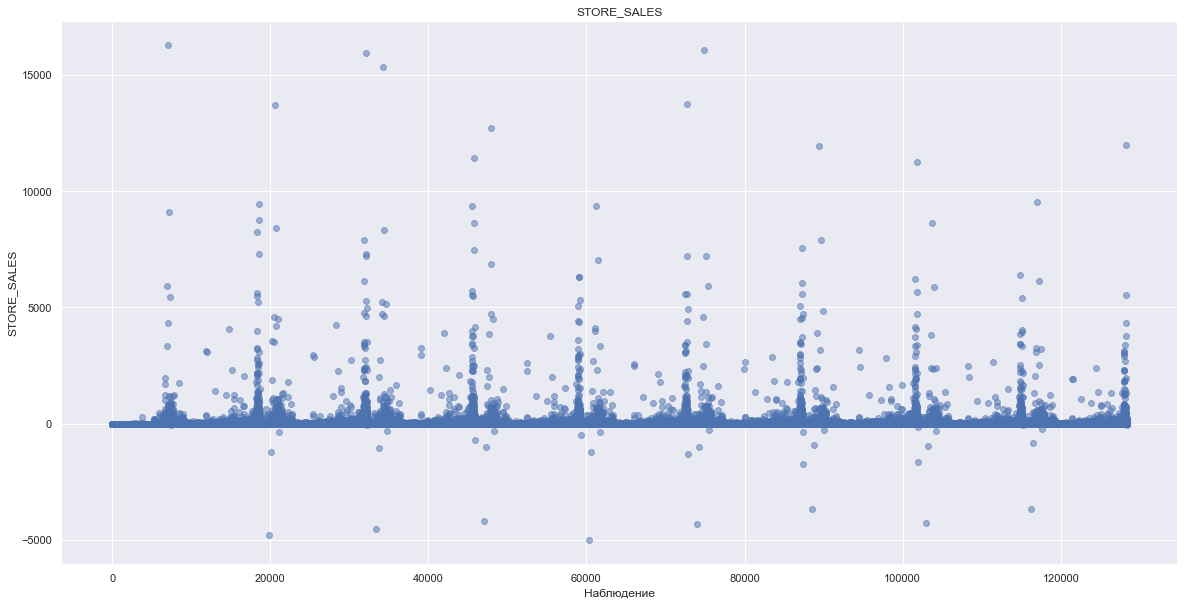

In [53]:
store_sal = data['STORE_SALES'].to_list()
plt.figure(figsize=(20, 10))
plt.scatter(range(len(store_sal)), store_sal, alpha=0.5)
plt.title('STORE_SALES')
plt.ylabel('STORE_SALES')
plt.xlabel('Наблюдение')
plt.show()

## SALES

In [54]:
data.SALES.describe()

count    128355.000000
mean       6563.037435
std       28924.944352
min       -6490.000000
25%           0.000000
50%         330.000000
75%        3250.000000
max     1616600.000000
Name: SALES, dtype: float64

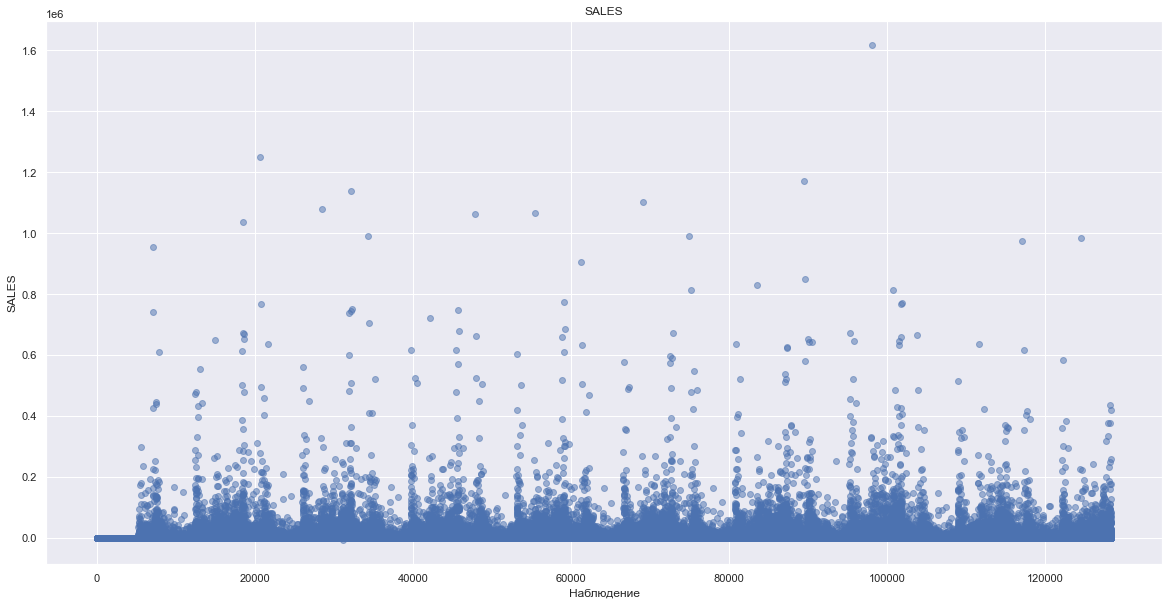

In [55]:
sales = data['SALES'].to_list()
plt.figure(figsize=(20, 10))
plt.scatter(range(len(sales)), sales, alpha=0.5)
plt.title('SALES')
plt.ylabel('SALES')
plt.xlabel('Наблюдение')
plt.show()

# Генерация признаков

In [56]:
data_features = data.copy()
data_features

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.000000,0.000000
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.000000,0.000000
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.000000,0.000000
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.000000,0.000000
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.000000,0.000000
...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,66460.000000,212.000000
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9080.000000,35.000000
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.000000,32.000000
128353,2018,2,UNKNOWN,BC,BEER CREDIT,REF,0.000000,-35.000000


## YEAR и MONTH

Полезного применения этих столбцов в качестве признаков найти не получилось, их отбрасываем.

In [57]:
data_features.drop('YEAR', axis=1, inplace=True)

## CONTRAGENT

Это категориальный признак, используем метод OHE с группировкой редко встречающихся категорий в одну.

In [58]:
rare_n = 25

In [59]:
for index, row in tqdm(data.iterrows()):
    if counter_contragent[row['CONTRAGENT']] < rare_n:
        data_features.at[index, 'CONTRAGENT'] = 'RARE_CONTRAGENT'

0it [00:00, ?it/s]

In [60]:
ohe_contragent = OneHotEncoder()
data_features = pd.concat([data_features, pd.DataFrame(ohe_contragent.fit_transform(data_features['CONTRAGENT'].to_numpy().reshape(-1, 1)).toarray(), columns=[f'CONTRAGENT={i}' for i in ohe_contragent.get_feature_names()])], axis=1)

In [61]:
data_features.drop('CONTRAGENT', axis=1, inplace=True)

In [62]:
data_features.head(3)

,MONTH,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,CONTRAGENT=x0_A I G WINE & SPIRITS,CONTRAGENT=x0_A VINTNERS SELECTIONS,CONTRAGENT=x0_A&E INC,CONTRAGENT=x0_AIKO IMPORTERS INC,CONTRAGENT=x0_ALLAGASH BREWING COMPANY,CONTRAGENT=x0_AMERICAN BEVERAGE CORPORATION,CONTRAGENT=x0_AMERICAN BEVERAGE MARKETERS,CONTRAGENT=x0_AMERICAN FIDELITY TRADING,CONTRAGENT=x0_ANHEUSER BUSCH INC,CONTRAGENT=x0_AREL GROUP WINE & SPIRITS,CONTRAGENT=x0_ARTISANS & VINES LLC,CONTRAGENT=x0_ASAHI BEER USA INC,CONTRAGENT=x0_ATLAS BREW WORKS LLC,CONTRAGENT=x0_AZIZ SHAFI TANNIC TONGUE,CONTRAGENT=x0_BACARDI USA INC,CONTRAGENT=x0_BACCHUS IMPORTERS LTD,CONTRAGENT=x0_BACKUP BEVERAGE,CONTRAGENT=x0_BANFI PRODUCTS CORP,CONTRAGENT=x0_BARON FRANCOIS LTD,CONTRAGENT=x0_BOND DISTRIBUTING CO,CONTRAGENT=x0_BOORDY VINEYARDS,CONTRAGENT=x0_BOSTON BEER CORPORATION,CONTRAGENT=x0_BOUTIQUE VINEYARDS LLC,CONTRAGENT=x0_BRONCO WINE COMPANY,CONTRAGENT=x0_BROWN-FORMAN BEVERAGES WORLDWIDE,CONTRAGENT=x0_BUCK DISTRIBUTING COMPANY INC,CONTRAGENT=x0_C MONDAVI & SONS,CONTRAGENT=x0_CABERNET CORPORATION,CONTRAGENT=x0_CAMPARI AMERICA LLC,CONTRAGENT=x0_CANTINIERE IMPORTS & DISTRIBUTING INC,CONTRAGENT=x0_CAPE STARZ WINE LLC,CONTRAGENT=x0_CASA CHIRICO LLC,CONTRAGENT=x0_CASTLE BRANDS USA CORP,CONTRAGENT=x0_CELICAR LLC DBA TWIN VALLEY DISTILLERS,CONTRAGENT=x0_CHEVAL QUANCARD,CONTRAGENT=x0_CLASSIC WINE IMPORTS INC DBA VISION WINE,CONTRAGENT=x0_CLIPPER CITY BREWING CO,CONTRAGENT=x0_COASTAL BREWING COMPANY LLC,CONTRAGENT=x0_COMETE WINES LLC,CONTRAGENT=x0_CONSTANTINE WINES INC,CONTRAGENT=x0_CONSTELLATION BRANDS,CONTRAGENT=x0_COPPER CANE LLC,CONTRAGENT=x0_CRAFT WINE & SPIRITS OF MARYLAND LLC,CONTRAGENT=x0_CROWN IMPORTS,CONTRAGENT=x0_DANGEROUS WINE GROUP LLC,CONTRAGENT=x0_DC BRAU BREWING LLC,CONTRAGENT=x0_DELICATO FAMILY VINEYARDS,CONTRAGENT=x0_DELMAR BREWING COMPANY LLC,CONTRAGENT=x0_DESCHUTES BREWERY INC,CONTRAGENT=x0_DEUTSCH FAMILY WINE & SPIRITS,CONTRAGENT=x0_DIAGEO NORTH AMERICA INC,CONTRAGENT=x0_DIONYSOS IMPORTS INC,CONTRAGENT=x0_DISARONNO INTERNATIONAL LLC,CONTRAGENT=x0_DMV DISTRIBUTING LLC,CONTRAGENT=x0_DOGFISH HEAD CRAFT BREWERY,CONTRAGENT=x0_DOGFISH HEAD DISTILLERY LLC,CONTRAGENT=x0_DOMAINE SELECT WINE & SPIRITS LLC,CONTRAGENT=x0_DON SEBASTIANI & SONS,CONTRAGENT=x0_DOPS INC,CONTRAGENT=x0_DRAGON DISTILLERY LLC,CONTRAGENT=x0_DUCKHORN WINE COMPANY,CONTRAGENT=x0_DUCLAW BREWERY LLC,CONTRAGENT=x0_DUGGANS DISTILLERS PROD,CONTRAGENT=x0_DUVEL MOORTGAT USA LTD,CONTRAGENT=x0_Default,CONTRAGENT=x0_E & J GALLO WINERY,CONTRAGENT=x0_E M D SALES INC,CONTRAGENT=x0_EASTERN LIQUOR DISTRIBUTORS INC,CONTRAGENT=x0_ELITE WINES IMPORTS,CONTRAGENT=x0_ELK RUN VINEYARDS,CONTRAGENT=x0_EVEREST SPIRITS LLC,CONTRAGENT=x0_EXCELSIOR WINE COMPANY LLC,CONTRAGENT=x0_FERRARI CARANO WINERY,CONTRAGENT=x0_FETZER VINEYARDS,CONTRAGENT=x0_FIFTH GENERATION INC,CONTRAGENT=x0_FIVE GRAPES LLC,CONTRAGENT=x0_FLYING DOG BREWERY LLLP,CONTRAGENT=x0_FN CELLARS LLC,CONTRAGENT=x0_FRANCIS COPPOLA WINERY LLC,CONTRAGENT=x0_FREDERICK P WINNER LTD,CONTRAGENT=x0_FREDERICK WILDMAN & SONS,CONTRAGENT=x0_FREE RUN WINE MERCHANTS LLC,CONTRAGENT=x0_FREIXENET USA,CONTRAGENT=x0_FRONT PORCH MICRO WINERY LLC,CONTRAGENT=x0_FRUIT OF THE VINES INC,CONTRAGENT=x0_FX MATT BREWING CO,CONTRAGENT=x0_GAMBRINUS,CONTRAGENT=x0_GLOBAL OCEAN AND AIR CARGO SERVICES,CONTRAGENT=x0_GOOSE RIDGE LLC,CONTRAGENT=x0_GRAPES & BARLEY LLC,CONTRAGENT=x0_GRAPES OF SPAIN INC,CONTRAGENT=x0_GROTH VINEYARDS & WINERY,CONTRAGENT=x0_HARVEST IMPORTING LLC,CONTRAGENT=x0_HEAVEN HILL DISTILLERIES INC,CONTRAGENT=x0_HEINEKEN USA,CONTRAGENT=x0_HOME BREW MART INC,CONTRAGENT=x0_IMPERO WINE DISTRIBUTORS VIRGINIA INC,CONTRAGENT=x0_INFINIUM SPIRITS INC,CONTRAGENT=x0_INTERBALT PRODUCTS CORP,CONTRAGENT=x0_INTERNATIONAL CELLARS LLC,CONTRAGENT=x0_J LOHR WINERY,CONTRAGENT=x0_JACK POUST & COMPANY INC,CONTRAGENT=x0_JACKSON FAMILY ENTERPRISES INC,CONTRAGENT=x0_JIM BEAM BRANDS CO,CONTRAGENT=x0_JOHN GIVEN WINES INC,CONTRAGENT=x0_JORDAN VINEYARD,CONTRAGENT=x0_JOS VICTORI WINES,CONTRAGENT=x0_KAHN PAPER COMPANY I

## ARTICLE_CODE

Категориальный признак, судя по описанию, выполняющий ту же функцию, что и ARTICLE_NAME (количество уникальных значений примерно одинаковое). Этот признак отбрасываем.

In [63]:
data_features.drop('ARTICLE_CODE', axis=1, inplace=True)

## ARTICLE_GROUP

Это категориальный признак, используем метод OHE.

In [64]:
ohe_article_group = OneHotEncoder()
data_features = pd.concat([data_features, pd.DataFrame(ohe_article_group.fit_transform(data_features['ARTICLE_GROUP'].to_numpy().reshape(-1, 1)).toarray(), columns=[f'ARTICLE_GROUP={i}' for i in ohe_article_group.get_feature_names()])], axis=1)

In [65]:
data_features.drop('ARTICLE_GROUP', axis=1, inplace=True)

In [66]:
data_features.head(3)

,MONTH,ARTICLE_NAME,SALES,STORE_SALES,CONTRAGENT=x0_A I G WINE & SPIRITS,CONTRAGENT=x0_A VINTNERS SELECTIONS,CONTRAGENT=x0_A&E INC,CONTRAGENT=x0_AIKO IMPORTERS INC,CONTRAGENT=x0_ALLAGASH BREWING COMPANY,CONTRAGENT=x0_AMERICAN BEVERAGE CORPORATION,CONTRAGENT=x0_AMERICAN BEVERAGE MARKETERS,CONTRAGENT=x0_AMERICAN FIDELITY TRADING,CONTRAGENT=x0_ANHEUSER BUSCH INC,CONTRAGENT=x0_AREL GROUP WINE & SPIRITS,CONTRAGENT=x0_ARTISANS & VINES LLC,CONTRAGENT=x0_ASAHI BEER USA INC,CONTRAGENT=x0_ATLAS BREW WORKS LLC,CONTRAGENT=x0_AZIZ SHAFI TANNIC TONGUE,CONTRAGENT=x0_BACARDI USA INC,CONTRAGENT=x0_BACCHUS IMPORTERS LTD,CONTRAGENT=x0_BACKUP BEVERAGE,CONTRAGENT=x0_BANFI PRODUCTS CORP,CONTRAGENT=x0_BARON FRANCOIS LTD,CONTRAGENT=x0_BOND DISTRIBUTING CO,CONTRAGENT=x0_BOORDY VINEYARDS,CONTRAGENT=x0_BOSTON BEER CORPORATION,CONTRAGENT=x0_BOUTIQUE VINEYARDS LLC,CONTRAGENT=x0_BRONCO WINE COMPANY,CONTRAGENT=x0_BROWN-FORMAN BEVERAGES WORLDWIDE,CONTRAGENT=x0_BUCK DISTRIBUTING COMPANY INC,CONTRAGENT=x0_C MONDAVI & SONS,CONTRAGENT=x0_CABERNET CORPORATION,CONTRAGENT=x0_CAMPARI AMERICA LLC,CONTRAGENT=x0_CANTINIERE IMPORTS & DISTRIBUTING INC,CONTRAGENT=x0_CAPE STARZ WINE LLC,CONTRAGENT=x0_CASA CHIRICO LLC,CONTRAGENT=x0_CASTLE BRANDS USA CORP,CONTRAGENT=x0_CELICAR LLC DBA TWIN VALLEY DISTILLERS,CONTRAGENT=x0_CHEVAL QUANCARD,CONTRAGENT=x0_CLASSIC WINE IMPORTS INC DBA VISION WINE,CONTRAGENT=x0_CLIPPER CITY BREWING CO,CONTRAGENT=x0_COASTAL BREWING COMPANY LLC,CONTRAGENT=x0_COMETE WINES LLC,CONTRAGENT=x0_CONSTANTINE WINES INC,CONTRAGENT=x0_CONSTELLATION BRANDS,CONTRAGENT=x0_COPPER CANE LLC,CONTRAGENT=x0_CRAFT WINE & SPIRITS OF MARYLAND LLC,CONTRAGENT=x0_CROWN IMPORTS,CONTRAGENT=x0_DANGEROUS WINE GROUP LLC,CONTRAGENT=x0_DC BRAU BREWING LLC,CONTRAGENT=x0_DELICATO FAMILY VINEYARDS,CONTRAGENT=x0_DELMAR BREWING COMPANY LLC,CONTRAGENT=x0_DESCHUTES BREWERY INC,CONTRAGENT=x0_DEUTSCH FAMILY WINE & SPIRITS,CONTRAGENT=x0_DIAGEO NORTH AMERICA INC,CONTRAGENT=x0_DIONYSOS IMPORTS INC,CONTRAGENT=x0_DISARONNO INTERNATIONAL LLC,CONTRAGENT=x0_DMV DISTRIBUTING LLC,CONTRAGENT=x0_DOGFISH HEAD CRAFT BREWERY,CONTRAGENT=x0_DOGFISH HEAD DISTILLERY LLC,CONTRAGENT=x0_DOMAINE SELECT WINE & SPIRITS LLC,CONTRAGENT=x0_DON SEBASTIANI & SONS,CONTRAGENT=x0_DOPS INC,CONTRAGENT=x0_DRAGON DISTILLERY LLC,CONTRAGENT=x0_DUCKHORN WINE COMPANY,CONTRAGENT=x0_DUCLAW BREWERY LLC,CONTRAGENT=x0_DUGGANS DISTILLERS PROD,CONTRAGENT=x0_DUVEL MOORTGAT USA LTD,CONTRAGENT=x0_Default,CONTRAGENT=x0_E & J GALLO WINERY,CONTRAGENT=x0_E M D SALES INC,CONTRAGENT=x0_EASTERN LIQUOR DISTRIBUTORS INC,CONTRAGENT=x0_ELITE WINES IMPORTS,CONTRAGENT=x0_ELK RUN VINEYARDS,CONTRAGENT=x0_EVEREST SPIRITS LLC,CONTRAGENT=x0_EXCELSIOR WINE COMPANY LLC,CONTRAGENT=x0_FERRARI CARANO WINERY,CONTRAGENT=x0_FETZER VINEYARDS,CONTRAGENT=x0_FIFTH GENERATION INC,CONTRAGENT=x0_FIVE GRAPES LLC,CONTRAGENT=x0_FLYING DOG BREWERY LLLP,CONTRAGENT=x0_FN CELLARS LLC,CONTRAGENT=x0_FRANCIS COPPOLA WINERY LLC,CONTRAGENT=x0_FREDERICK P WINNER LTD,CONTRAGENT=x0_FREDERICK WILDMAN & SONS,CONTRAGENT=x0_FREE RUN WINE MERCHANTS LLC,CONTRAGENT=x0_FREIXENET USA,CONTRAGENT=x0_FRONT PORCH MICRO WINERY LLC,CONTRAGENT=x0_FRUIT OF THE VINES INC,CONTRAGENT=x0_FX MATT BREWING CO,CONTRAGENT=x0_GAMBRINUS,CONTRAGENT=x0_GLOBAL OCEAN AND AIR CARGO SERVICES,CONTRAGENT=x0_GOOSE RIDGE LLC,CONTRAGENT=x0_GRAPES & BARLEY LLC,CONTRAGENT=x0_GRAPES OF SPAIN INC,CONTRAGENT=x0_GROTH VINEYARDS & WINERY,CONTRAGENT=x0_HARVEST IMPORTING LLC,CONTRAGENT=x0_HEAVEN HILL DISTILLERIES INC,CONTRAGENT=x0_HEINEKEN USA,CONTRAGENT=x0_HOME BREW MART INC,CONTRAGENT=x0_IMPERO WINE DISTRIBUTORS VIRGINIA INC,CONTRAGENT=x0_INFINIUM SPIRITS INC,CONTRAGENT=x0_INTERBALT PRODUCTS CORP,CONTRAGENT=x0_INTERNATIONAL CELLARS LLC,CONTRAGENT=x0_J LOHR WINERY,CONTRAGENT=x0_JACK POUST & COMPANY INC,CONTRAGENT=x0_JACKSON FAMILY ENTERPRISES INC,CONTRAGENT=x0_JIM BEAM BRANDS CO,CONTRAGENT=x0_JOHN GIVEN WINES INC,CONTRAGENT=x0_JORDAN VINEYARD,CONTRAGENT=x0_JOS VICTORI WINES,CONTRAGENT=x0_KAHN PAPER COMPANY INC,CONTRAGENT=x0_KATCEF BRO

## STORE_SALES

Количественный признак, остаётся как есть.

## ARTICLE_NAME

Использовать данный условно категориальный признак для OHE слишком затратно по памяти, да и статистика их появлений слишком мала (max 19). Поэтому обработаем это как текстовый признак с помощью Tf-Idf.

In [67]:
stop_words = ['-', '']

In [68]:
ngram_range_ = (1, 1)
min_df_ = 40

In [69]:
def bag_of_words(dataframe, count_vec, col_name):
    df = dataframe.copy()
    x = count_vec.transform(df[col_name].to_list())
    cols_n = [f'{col_name}={c}' for c in count_vec.get_feature_names()]
    df_ = pd.DataFrame(x.toarray(), columns=cols_n, index=df.index)
    df = pd.concat([df, df_], axis=1)
    return df

In [70]:
def tf_idf(dataframe, tfidf, col_name):
    df = dataframe.copy()
    x = tfidf.transform(df[col_name].to_list())
    cols_n = [f'{col_name}={c}' for c in tfidf.get_feature_names()]
    df_ = pd.DataFrame(x.toarray(), columns=cols_n, index=df.index)
    df = pd.concat([df, df_], axis=1)
    return df

In [71]:
def lemmatize(text):
    words = text.lower()
    words = nltk.word_tokenize(words)
    words = [word for word in words if word not in stop_words]
    res = ' '.join(words)
    return res

In [72]:
def article_name_transform(dataframe):
    df = dataframe.copy()
    df['article_name_number_of_words'] = df['ARTICLE_NAME'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['article_name_number_of_characters'] = df['ARTICLE_NAME'].apply(lambda x: len(x))
    df['ARTICLE_NAME'] = df['ARTICLE_NAME'].apply(lambda x: lemmatize(x))
    return df

In [73]:
data_features = article_name_transform(data_features)

In [74]:
data_features.head(3)

,MONTH,ARTICLE_NAME,SALES,STORE_SALES,CONTRAGENT=x0_A I G WINE & SPIRITS,CONTRAGENT=x0_A VINTNERS SELECTIONS,CONTRAGENT=x0_A&E INC,CONTRAGENT=x0_AIKO IMPORTERS INC,CONTRAGENT=x0_ALLAGASH BREWING COMPANY,CONTRAGENT=x0_AMERICAN BEVERAGE CORPORATION,CONTRAGENT=x0_AMERICAN BEVERAGE MARKETERS,CONTRAGENT=x0_AMERICAN FIDELITY TRADING,CONTRAGENT=x0_ANHEUSER BUSCH INC,CONTRAGENT=x0_AREL GROUP WINE & SPIRITS,CONTRAGENT=x0_ARTISANS & VINES LLC,CONTRAGENT=x0_ASAHI BEER USA INC,CONTRAGENT=x0_ATLAS BREW WORKS LLC,CONTRAGENT=x0_AZIZ SHAFI TANNIC TONGUE,CONTRAGENT=x0_BACARDI USA INC,CONTRAGENT=x0_BACCHUS IMPORTERS LTD,CONTRAGENT=x0_BACKUP BEVERAGE,CONTRAGENT=x0_BANFI PRODUCTS CORP,CONTRAGENT=x0_BARON FRANCOIS LTD,CONTRAGENT=x0_BOND DISTRIBUTING CO,CONTRAGENT=x0_BOORDY VINEYARDS,CONTRAGENT=x0_BOSTON BEER CORPORATION,CONTRAGENT=x0_BOUTIQUE VINEYARDS LLC,CONTRAGENT=x0_BRONCO WINE COMPANY,CONTRAGENT=x0_BROWN-FORMAN BEVERAGES WORLDWIDE,CONTRAGENT=x0_BUCK DISTRIBUTING COMPANY INC,CONTRAGENT=x0_C MONDAVI & SONS,CONTRAGENT=x0_CABERNET CORPORATION,CONTRAGENT=x0_CAMPARI AMERICA LLC,CONTRAGENT=x0_CANTINIERE IMPORTS & DISTRIBUTING INC,CONTRAGENT=x0_CAPE STARZ WINE LLC,CONTRAGENT=x0_CASA CHIRICO LLC,CONTRAGENT=x0_CASTLE BRANDS USA CORP,CONTRAGENT=x0_CELICAR LLC DBA TWIN VALLEY DISTILLERS,CONTRAGENT=x0_CHEVAL QUANCARD,CONTRAGENT=x0_CLASSIC WINE IMPORTS INC DBA VISION WINE,CONTRAGENT=x0_CLIPPER CITY BREWING CO,CONTRAGENT=x0_COASTAL BREWING COMPANY LLC,CONTRAGENT=x0_COMETE WINES LLC,CONTRAGENT=x0_CONSTANTINE WINES INC,CONTRAGENT=x0_CONSTELLATION BRANDS,CONTRAGENT=x0_COPPER CANE LLC,CONTRAGENT=x0_CRAFT WINE & SPIRITS OF MARYLAND LLC,CONTRAGENT=x0_CROWN IMPORTS,CONTRAGENT=x0_DANGEROUS WINE GROUP LLC,CONTRAGENT=x0_DC BRAU BREWING LLC,CONTRAGENT=x0_DELICATO FAMILY VINEYARDS,CONTRAGENT=x0_DELMAR BREWING COMPANY LLC,CONTRAGENT=x0_DESCHUTES BREWERY INC,CONTRAGENT=x0_DEUTSCH FAMILY WINE & SPIRITS,CONTRAGENT=x0_DIAGEO NORTH AMERICA INC,CONTRAGENT=x0_DIONYSOS IMPORTS INC,CONTRAGENT=x0_DISARONNO INTERNATIONAL LLC,CONTRAGENT=x0_DMV DISTRIBUTING LLC,CONTRAGENT=x0_DOGFISH HEAD CRAFT BREWERY,CONTRAGENT=x0_DOGFISH HEAD DISTILLERY LLC,CONTRAGENT=x0_DOMAINE SELECT WINE & SPIRITS LLC,CONTRAGENT=x0_DON SEBASTIANI & SONS,CONTRAGENT=x0_DOPS INC,CONTRAGENT=x0_DRAGON DISTILLERY LLC,CONTRAGENT=x0_DUCKHORN WINE COMPANY,CONTRAGENT=x0_DUCLAW BREWERY LLC,CONTRAGENT=x0_DUGGANS DISTILLERS PROD,CONTRAGENT=x0_DUVEL MOORTGAT USA LTD,CONTRAGENT=x0_Default,CONTRAGENT=x0_E & J GALLO WINERY,CONTRAGENT=x0_E M D SALES INC,CONTRAGENT=x0_EASTERN LIQUOR DISTRIBUTORS INC,CONTRAGENT=x0_ELITE WINES IMPORTS,CONTRAGENT=x0_ELK RUN VINEYARDS,CONTRAGENT=x0_EVEREST SPIRITS LLC,CONTRAGENT=x0_EXCELSIOR WINE COMPANY LLC,CONTRAGENT=x0_FERRARI CARANO WINERY,CONTRAGENT=x0_FETZER VINEYARDS,CONTRAGENT=x0_FIFTH GENERATION INC,CONTRAGENT=x0_FIVE GRAPES LLC,CONTRAGENT=x0_FLYING DOG BREWERY LLLP,CONTRAGENT=x0_FN CELLARS LLC,CONTRAGENT=x0_FRANCIS COPPOLA WINERY LLC,CONTRAGENT=x0_FREDERICK P WINNER LTD,CONTRAGENT=x0_FREDERICK WILDMAN & SONS,CONTRAGENT=x0_FREE RUN WINE MERCHANTS LLC,CONTRAGENT=x0_FREIXENET USA,CONTRAGENT=x0_FRONT PORCH MICRO WINERY LLC,CONTRAGENT=x0_FRUIT OF THE VINES INC,CONTRAGENT=x0_FX MATT BREWING CO,CONTRAGENT=x0_GAMBRINUS,CONTRAGENT=x0_GLOBAL OCEAN AND AIR CARGO SERVICES,CONTRAGENT=x0_GOOSE RIDGE LLC,CONTRAGENT=x0_GRAPES & BARLEY LLC,CONTRAGENT=x0_GRAPES OF SPAIN INC,CONTRAGENT=x0_GROTH VINEYARDS & WINERY,CONTRAGENT=x0_HARVEST IMPORTING LLC,CONTRAGENT=x0_HEAVEN HILL DISTILLERIES INC,CONTRAGENT=x0_HEINEKEN USA,CONTRAGENT=x0_HOME BREW MART INC,CONTRAGENT=x0_IMPERO WINE DISTRIBUTORS VIRGINIA INC,CONTRAGENT=x0_INFINIUM SPIRITS INC,CONTRAGENT=x0_INTERBALT PRODUCTS CORP,CONTRAGENT=x0_INTERNATIONAL CELLARS LLC,CONTRAGENT=x0_J LOHR WINERY,CONTRAGENT=x0_JACK POUST & COMPANY INC,CONTRAGENT=x0_JACKSON FAMILY ENTERPRISES INC,CONTRAGENT=x0_JIM BEAM BRANDS CO,CONTRAGENT=x0_JOHN GIVEN WINES INC,CONTRAGENT=x0_JORDAN VINEYARD,CONTRAGENT=x0_JOS VICTORI WINES,CONTRAGENT=x0_KAHN PAPER COMPANY INC,CONTRAGENT=x0_KATCEF BRO

### Tf-Idf

In [75]:
TfIdfArticleName = TfidfVectorizer(ngram_range=ngram_range_, min_df=min_df_)
TfIdfArticleName.fit(data_features['ARTICLE_NAME'].to_list())

TfidfVectorizer(min_df=40)

In [76]:
print(len(TfIdfArticleName.get_feature_names()))
#print(TfIdfArticleName.get_feature_names())

1898


In [77]:
data_features = tf_idf(data_features, TfIdfArticleName, 'ARTICLE_NAME')

### Bag of Words

In [78]:
data_features.drop('ARTICLE_NAME', axis=1, inplace=True)

## Проверка корреляции признаков с целевой переменной

In [79]:
corr_ = data_features.corrwith(data_features['SALES']).sort_values(ascending=False)
with open('corr_sales.txt', 'w', encoding="utf-8") as file:
    for i, x in tqdm(corr_.iteritems()):
        file.write(f'{i} - {x}\n')
# for i, x in corr_.iteritems():
#     if i in pos_list:
#         print(f'{i} - {x}')

0it [00:00, ?it/s]

## Финальный датасет

In [80]:
data_features.head(3)

MONTH    SALES  STORE_SALES  CONTRAGENT=x0_A I G WINE & SPIRITS  \
0      4 0.000000     0.000000                            0.000000   
1      4 0.000000     0.000000                            0.000000   
2      4 0.000000     0.000000                            0.000000   

   CONTRAGENT=x0_A VINTNERS SELECTIONS  CONTRAGENT=x0_A&E INC  \
0                             0.000000               0.000000   
1                             0.000000               0.000000   
2                             0.000000               0.000000   

   CONTRAGENT=x0_AIKO IMPORTERS INC  CONTRAGENT=x0_ALLAGASH BREWING COMPANY  \
0                          0.000000                                0.000000   
1                          0.000000                                0.000000   
2                          0.000000                                0.000000   

   CONTRAGENT=x0_AMERICAN BEVERAGE CORPORATION  \
0                                     0.000000   
1                                     0.000000   
2                                     0.000000   

   CONTRAGENT=x0_AMERICAN BEVERAGE MARKETERS  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   

   CONTRAGENT=x0_AMERICAN FIDELITY TRADING  CONTRAGENT=x0_ANHEUSER BUSCH INC  \
0                                 0.000000                          0.000000   
1                                 0.000000                          0.000000   
2                                 0.000000                          0.000000   

   CONTRAGENT=x0_AREL GROUP WINE & SPIRITS  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   

   CONTRAGENT=x0_ARTISANS & VINES LLC  CONTRAGENT=x0_ASAHI BEER USA INC  \
0                            0.000000                          0.000000   
1                            0.000000                          0.000000   
2                            0.000000                          0.000000   

   CONTRAGENT=x0_ATLAS BREW WORKS LLC  CONTRAGENT=x0_AZIZ SHAFI TANNIC TONGUE  \
0                            0.000000                                0.000000   
1                            0.000000                                0.000000   
2                            0.000000                                0.000000   

   CONTRAGENT=x0_BACARDI USA INC  CONTRAGENT=x0_BACCHUS IMPORTERS LTD  \
0                       0.000000                             0.000000   
1                       0.000000                             0.000000   
2                       0.000000                             0.000000   

   CONTRAGENT=x0_BACKUP BEVERAGE  CONTRAGENT=x0_BANFI PRODUCTS CORP  \
0                       0.000000                           0.000000   
1                       0.000000                           0.000000   
2                       0.000000                           0.000000   

   CONTRAGENT=x0_BARON FRANCOIS LTD  CONTRAGENT=x0_BOND DISTRIBUTING CO  \
0                          0.000000                            0.000000   
1                          0.000000                            0.000000   
2                          0.000000                            0.000000   

   CONTRAGENT=x0_BOORDY VINEYARDS  CONTRAGENT=x0_BOSTON BEER CORPORATION  \
0                        0.000000                               0.000000   
1                        0.000000                               0.000000   
2                        0.000000                               0.000000   

   CONTRAGENT=x0_BOUTIQUE VINEYARDS LLC  CONTRAGENT=x0_BRONCO WINE COMPANY  \
0                              0.000000                           0.000000   
1                              0.000000                           0.000000   
2                              0.000000                           0.000000   

   CONTRAGENT=x0_BROWN-FORMAN BEVERAGES WORLDWIDE  \
0                                        0.000000   
1              

In [81]:
data_features.shape

(128355, 2138)

# Тестирование модели

## Создание обучающей и тестовой выборок

In [82]:
data_train = data_features.loc[data_features['MONTH'] != 2]
data_train.drop('MONTH', axis=1, inplace=True)
data_train.shape

(115255, 2137)

In [83]:
data_test = data_features.loc[data_features['MONTH'] == 2]
data_test.drop('MONTH', axis=1, inplace=True)
data_test.shape

(13100, 2137)

In [84]:
#data_train.to_csv('reg_train.csv', index=False)

In [85]:
#data_test.to_csv('reg_test.csv', index=False)

## Обучение модели CatBoostRegressor

In [86]:
def custom_metric(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [87]:
train_x = data_train.drop('SALES', axis=1)
train_y = data_train['SALES']
test_x = data_test.drop('SALES', axis=1)
test_y = data_test['SALES']

In [88]:
pool_train = Pool(train_x, train_y)
pool_eval = Pool(test_x, test_y)
pool_test = Pool(test_x)

## Подбор параметров

Весомых улучшений подбор гиперпараметров не дал.

In [89]:
cbr = CatBoostRegressor(verbose=100)

In [90]:
cbr.fit(pool_train, eval_set=pool_eval, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.107294
0:	learn: 28192.0691757	test: 23745.4288531	best: 23745.4288531 (0)	total: 181ms	remaining: 3m
100:	learn: 14132.6337886	test: 11298.1998743	best: 11298.1998743 (100)	total: 4.51s	remaining: 40.2s
200:	learn: 12348.0257095	test: 9934.0570532	best: 9934.0570532 (200)	total: 8.86s	remaining: 35.2s
300:	learn: 11373.2087799	test: 9285.3932386	best: 9285.3932386 (300)	total: 13.7s	remaining: 31.7s
400:	learn: 10777.3253191	test: 8861.0081654	best: 8861.0081654 (400)	total: 18.6s	remaining: 27.9s
500:	learn: 10341.0307183	test: 8636.9020130	best: 8636.9020130 (500)	total: 23.4s	remaining: 23.3s
600:	learn: 10018.5989916	test: 8491.6443191	best: 8491.6443191 (600)	total: 28s	remaining: 18.6s
700:	learn: 9761.0728507	test: 8397.7480515	best: 8390.4441319 (696)	total: 32.5s	remaining: 13.9s
800:	learn: 9537.4625212	test: 8319.3996525	best: 8319.3996525 (800)	total: 36.9s	remaining: 9.16s
900:	learn: 9337.4857773	test: 8255.4878090	best: 8251.0623248 (896)	total: 4

## Важность признаков

In [91]:
features_importance = pd.DataFrame({'feature_importance': cbr.get_feature_importance(pool_train), 'feature_names': train_x.columns}).sort_values(by=['feature_importance'], ascending=False)
for index, row in features_importance.iterrows():
    if row['feature_importance'] >= 0.01: 
        print('{0} : {1}'.format(row['feature_names'], row['feature_importance']))

STORE_SALES : 41.52895506707542
ARTICLE_NAME=75l : 9.41739463821769
ARTICLE_NAME=12 : 7.717567290836875
ARTICLE_NAME=nr : 5.49172368605626
ARTICLE_NAME=18pk : 2.3924320718676704
article_name_number_of_characters : 2.034232204175587
ARTICLE_NAME=loose : 1.9792744753416172
ARTICLE_NAME=tito : 1.944589770851183
ARTICLE_GROUP=x0_WINE : 1.8022210352598669
ARTICLE_GROUP=x0_LIQUOR : 1.5562932674900327
ARTICLE_NAME=handmade : 1.524481734879826
article_name_number_of_words : 1.193103015127739
ARTICLE_NAME=bowman : 1.0628378039075885
ARTICLE_NAME=30pk : 0.9618146668857329
ARTICLE_NAME=vodka : 0.8155893046566944
ARTICLE_NAME=12oz : 0.7912072617149767
ARTICLE_NAME=bud : 0.6521657699756366
ARTICLE_NAME=daniels : 0.6323058689341747
ARTICLE_NAME=750ml : 0.5843929033352143
ARTICLE_NAME=24 : 0.5440929726724943
ARTICLE_NAME=smirnoff : 0.5383204674325722
ARTICLE_NAME=artois : 0.5251200559160494
ARTICLE_NAME=2oz : 0.4646922045966075
ARTICLE_NAME=5l : 0.39111897581327726
ARTICLE_NAME=light : 0.379908938288

## Оценка модели на тестовой выборке

In [92]:
y_pred = cbr.predict(pool_test)
print(f'Метрика: {custom_metric(test_y, y_pred)}')

Метрика: 53.025502207165374


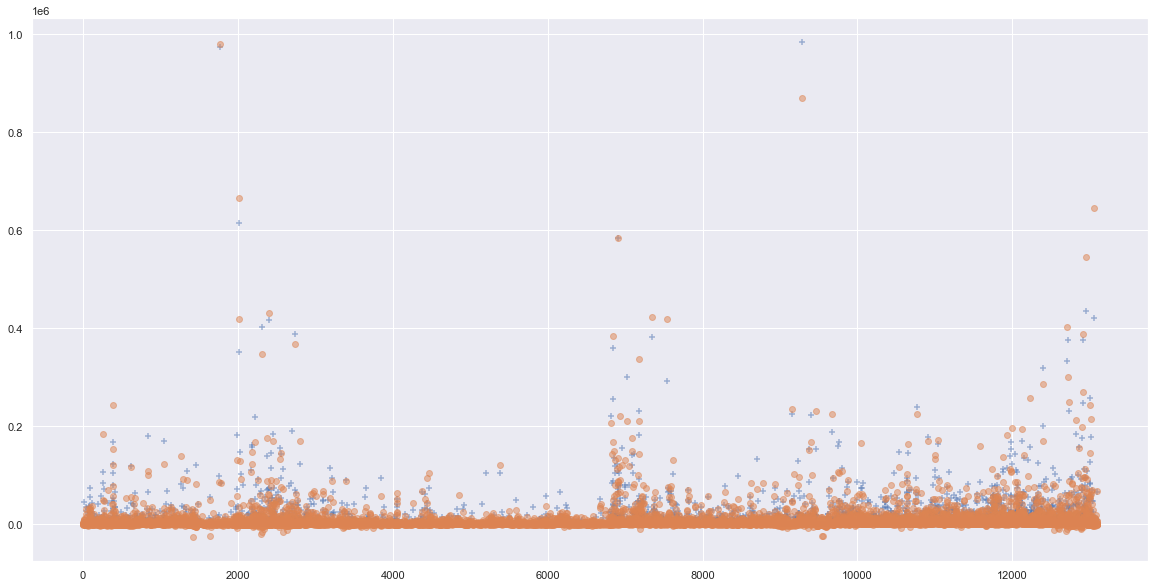

In [93]:
plt.figure(figsize=(20, 10))
plt.scatter(range(len(test_y)), test_y, alpha=0.5, marker='+')
plt.scatter(range(len(y_pred)), y_pred, alpha=0.5, marker='o')
plt.show()

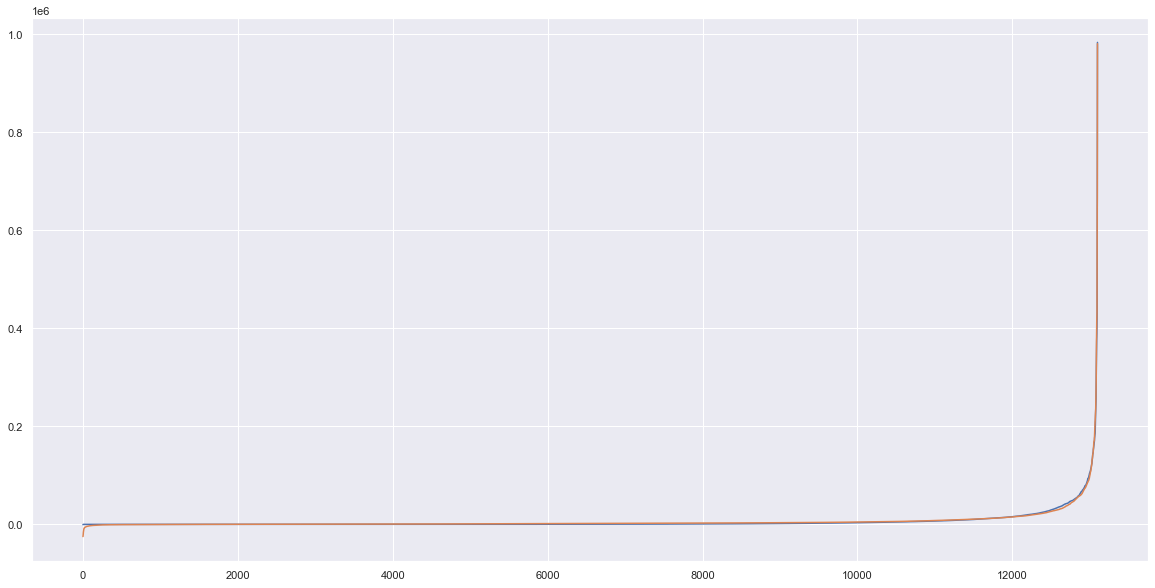

In [94]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(test_y)), sorted(test_y))
plt.plot(range(len(test_y)), sorted(y_pred))
plt.show()